In [2]:
#Let's import all that will be needed
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

#Some methods useful for preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV #For stratified sampling

#The bases for our custom transformation
from sklearn.base import BaseEstimator, TransformerMixin

#Some models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
sns.set()

cwd = os.getcwd()
#A metric for measuring RMSE
from sklearn.metrics import mean_squared_error

We fetch our data from githubusercontent

In [4]:
cwd = os.getcwd()
data = os.path.join(cwd,"datasets/housing/housing.csv")
HousingData = pd.read_csv(data)

We split the whole data set for training purposes and stratified our data

In [5]:
HousingData["income_cat"] = np.ceil(HousingData["median_income"] / 1.5)
HousingData["income_cat"].where(HousingData["income_cat"] < 5, 5.0, inplace=True)

#We make stratification based on the income_cat that was obtained with median_income
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(HousingData, HousingData["income_cat"]):
    strat_train_set = HousingData.loc[train_index]
    strat_test_set = HousingData.loc[test_index]

Now we remove "income_cat" after stratifying the set. So we get our set as before. 

And create a copy of our housing data

In [6]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


We separate our data into numerical and categorical and adapt the last one. 

Then we create a custom transform for adding extra attributes. and use the column transformer to transform categorical and numerical data correspondingly.

In [8]:
housing_num = housing.drop("ocean_proximity", axis = 1)
#Indices of columns in our data frame
rooms_ix, bedrooms_ix, population_ix, households_ix = 4,5,6,7

class Combinations(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
#Transformations for numerical data: Imputation, combinations and scaling     
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", Combinations()),
    ("std_scaler", StandardScaler()),
])

#We specify the attributes that are numerical and categorical
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

#Combining the previous transformation with the categorical one hot encoder
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

Let's start training and evaluating on the training set.

We use mean_squared_error to get this model's RMSE.

# Linear Regression Model:

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#We gain an inside of prediction and real value
#some_data = housing.iloc[:10]
#some_labels = housing_labels.iloc[:10]
#some_data_prepared = full_pipeline.transform(some_data)
#for pred, real in zip(lin_reg.predict(some_data_prepared), list(some_labels)):
#    print("Prediction :", pred, "- Real Value :", real) 

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
lin_rmse

69036.32451019084

# Decision Tree Model:

In [10]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions_tree))
tree_rmse


0.0

Obviously there is some overfitting with this model.

# Random Forest Model:

In [11]:
forest_reg = RandomForestRegressor(n_estimators = 30, max_features = 8)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions_forest = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions_forest))
forest_rmse

19892.792878064734

# Cross-validation for avoiding overfitting
The previous result show us that there may be some data overfitting.

A great alternative is to use Scikit-Learn’s cross-validation feature. The following code performs K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds.

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [12]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 71979.24258671  67981.35429486  72969.56111189  75043.34885301
  74854.99351058  75729.15525224  70744.43380248  69704.60903042
  72471.55244254  71837.14839356]
Mean: 72331.5399278
Standard deviation: 2332.47750898


We do the same for the linear regression model

In [13]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 67469.28784592  67422.28193468  68356.19928133  74785.20131013
  68241.17784274  71620.02931289  65379.21201448  68578.87113789
  73052.42414895  68092.44973869]
Mean: 69299.7134568
Standard deviation: 2753.0098942


We do the same for random forest

In [14]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 50143.85598465  48100.56774906  49680.43149013  53202.00545393
  51376.93882514  54031.32356752  49848.90765019  50171.7030653
  53699.05252248  50480.11150741]
Mean: 51073.4897816
Standard deviation: 1859.38255791


We see that random Forest is actually the most accurate model for predicting housing costs

# Support Vector Machines - Regressor

In [19]:
best_param = {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'} #I got these values from doing randomized search
VectorMach_reg = SVR(**best_param)
VectorMach_reg.fit(housing_prepared, housing_labels)
#SVR_scores = cross_val_score(VectorMach_reg, housing_prepared, housing_labels,
#                         scoring="neg_mean_squared_error", cv=10)
#SVR_rmse_scores = np.sqrt(-SVR_scores)
#display_scores(SVR_scores)
housing_predictions_VectorMach = VectorMach_reg.predict(housing_prepared)
VectorMach_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions_VectorMach))
VectorMach_rmse

50078.719873647897

# ------------------------------Too long to be computed-----------------avoid if not needed

So far SVM seems to be the best solution for predicting housing values.

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024D41DADD30>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024D45737278>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [15]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50681.6021466 {'max_features': 7, 'n_estimators': 180}
53434.1465117 {'max_features': 5, 'n_estimators': 15}
52778.836354 {'max_features': 3, 'n_estimators': 72}
52537.4679252 {'max_features': 5, 'n_estimators': 21}
50762.126242 {'max_features': 7, 'n_estimators': 122}
52748.7755502 {'max_features': 3, 'n_estimators': 75}
52557.2964939 {'max_features': 3, 'n_estimators': 88}
51520.3047696 {'max_features': 5, 'n_estimators': 100}
52427.1765887 {'max_features': 3, 'n_estimators': 150}
67348.1147123 {'max_features': 5, 'n_estimators': 2}


We define the class for returning top k important features In case we want to build our model based on the top k important features.

In [16]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature = feature_importances
        self.k = k
    def fit(self, X, y = None):
        self.feature_indices = indices_of_top_k(self.feature, self.k)
        return self
    def transform(self, X):
        return(X[:,self.feature_indices])

In [17]:
k = 5
Pipeline_important_features = Pipeline([
    ("full_pipeline", full_pipeline),
    ("feature_selection", FeatureSelector(feature_importances, k))
])

Housing_prepared_selectedfeatures = Pipeline_important_features.fit_transform(housing)

NameError: name 'feature_importances' is not defined

In [ ]:
Housing_prepared_selectedfeatures[0:3]

# ---------------------------------------------------------------------------------------------------------------

# Full_pipeline implementation and fitting the model

Creating a single pipeline that does the full data preparation plus the final prediction.

In [21]:
Pipeline_important_features_prediction= Pipeline([
    ("full_pipeline", full_pipeline),
    ("SVM_reg", SVR(**best_param))
])
Pipeline_predictions = Pipeline_important_features_prediction.fit(housing, housing_labels)

In [22]:
Predictions_SVR = 
fullpipeline_rmse = np.sqrt(mean_squared_error(housing_labels, Pipeline_predictions))
fullpipeline_rmse

TypeError: Expected sequence or array-like, got estimator Pipeline(memory=None,
     steps=[('full_pipeline', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verb... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

# Predictions vs labels comparison

In [23]:
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]

print("Predictions:\t", Pipeline_important_features_prediction.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 219714.79825317  329721.55953234  206292.00473373   52297.68485334
  169127.78385177  127623.10491451  517382.52548386  179219.57941867
  105911.43742588  177972.59476933]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0, 500001.0]


In [24]:
some_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [25]:
some_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [27]:
housingtest = strat_test_set.copy()
housingtest_labels = strat_test_set.drop("median_house_value",axis = 1)
housing_labels = strat_test_set["median_house_value"].copy()
#housingtest_num = housingtest.drop("ocean_proximity", axis = 1)
#num_attribs = list(housingtest_num)
#cat_attribs = ["ocean_proximity"]
#housingtest_prepared = full_pipeline.fit_transform(housingtest)
print("Predictions in test:",Pipeline_important_features_prediction.predict(housingtest))

Predictions in test: [ 485516.67992922  272480.12705824  271610.0069403  ...,  343884.8704957
  149747.69883171  141866.1421861 ]


In [28]:
print("Real Values in test:", housing_labels)

Real Values in test: 5241     500001.0
10970    240300.0
20351    218200.0
6568     182100.0
13285    121300.0
20552    120600.0
19989     72300.0
17049    500001.0
13692     98900.0
13916     82600.0
20374    399400.0
18776     78600.0
16531    212500.0
14690    174100.0
17812    258100.0
16570    121400.0
5814     221900.0
5473     334700.0
7888     337400.0
5376     340400.0
10383    184800.0
16815    272700.0
11142    180000.0
2554      72200.0
14472    274400.0
5986     212500.0
15825    400000.0
6472     251600.0
4309     208800.0
20066    105200.0
           ...   
2735      62500.0
918      196900.0
2343      93600.0
9989     143400.0
7560     118100.0
2286      75100.0
11342    161800.0
11438    363100.0
15190    261500.0
1075      97000.0
17934    235500.0
9498     158800.0
13279    115800.0
2344      88900.0
3118      54300.0
11782    136500.0
11298    177900.0
15643    287500.0
455      287500.0
4038     500001.0
5353     500001.0
15763    412500.0
3239      64700.0
13114  

In [30]:
housingtest["predictions"] = Pipeline_important_features_prediction.predict(housingtest)

In [31]:
housingtest.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,predictions
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,485516.679929
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,272480.127058
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,271610.006940
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,213045.768809
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,144150.347461


Let's plot our predictions in our geographical area

In [35]:
Error = np.sqrt(mean_squared_error(housingtest["median_house_value"], housingtest["predictions"]))
Error

52821.640087105035

In [32]:
california_img=mpimg.imread("california.png")

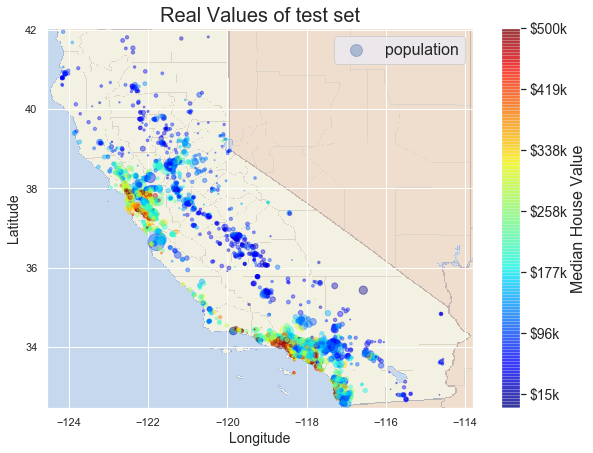

In [37]:
#Scatter of house prices
ax = housingtest.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housingtest["population"]/100,label="population",  figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False,
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

#California image as background
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

#Median House value bar
cheapest = housingtest.median_house_value.min()
most_expensive = housingtest.median_house_value.max()
tick_values = np.linspace(cheapest, most_expensive, 7, endpoint=True)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)
plt.title("Real Values of test set", fontsize = 20)
plt.legend(fontsize=16)
plt.savefig("RealValues_test")
plt.show()

In [39]:
housingtest.loc[housingtest.predictions > 500000, "predictions"] = 500000

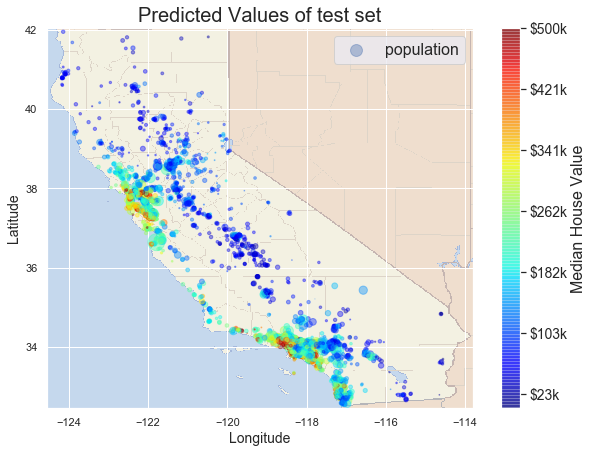

In [40]:
#Scatter of house prices
ax = housingtest.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housingtest["population"]/100,label="population",  figsize=(10,7),
    c="predictions", cmap=plt.get_cmap("jet"), colorbar=False,
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

#California image as background
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

#Median House value bar
cheapest = housingtest.predictions.min()
most_expensive = housingtest.predictions.max()
tick_values = np.linspace(cheapest, most_expensive, 7, endpoint=True)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)
plt.title("Predicted Values of test set", fontsize = 20)
plt.legend(fontsize=16)
plt.savefig("PredictedValues_test")
plt.show()

We can see that our model is actually very accurate, compact version with only pipelines are to be done later on for this project.